In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def ensure_uint8(image):
    if image.dtype != np.uint8:
        # 正規化されている場合（0〜1）、0〜255にスケール
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)
    return image


def compute_optical_flow_lk(frame_a, frame_b, feature_params, lk_params):
    frame_a = ensure_uint8(frame_a)
    frame_b = ensure_uint8(frame_b)

    # 特徴点の検出
    p0 = cv2.goodFeaturesToTrack(frame_a, mask=None, **feature_params)
    if p0 is None:
        raise ValueError("特徴点が検出されませんでした。フレームの内容やパラメータを確認してください。")

    # オプティカルフローの計算
    p1, st, err = cv2.calcOpticalFlowPyrLK(frame_a, frame_b, p0, None, **lk_params)

    # 有効なフローのみを抽出
    good_p0 = p0[st == 1]
    good_p1 = p1[st == 1]

    # フローベクトルを計算
    flow = good_p1 - good_p0

    return good_p0, flow


def warp_frame(frame, points, flow, scale=0.5):
    h, w = frame.shape[:2]
    warped = np.zeros_like(frame)

    for (x, y), (dx, dy) in zip(points, flow):
        src_x = int(x + dx * scale)
        src_y = int(y + dy * scale)

        if 0 <= src_x < w and 0 <= src_y < h:
            warped[src_y, src_x] = frame[int(y), int(x)]

    # 欠損部分を補完（ここでは単純にコピー）
    warped = cv2.blur(warped, (5, 5))

    return warped


def estimate_middle_frame_lk(frame_a, frame_b, feature_params, lk_params):
    # オプティカルフローの計算
    points, flow = compute_optical_flow_lk(frame_a, frame_b, feature_params, lk_params)

    # フレームAからCへのワープ
    warped_a = warp_frame(frame_a, points, flow, scale=0.5)

    # フレームBからCへのワープ（逆方向のフロー）
    warped_b = warp_frame(frame_b, points, -flow, scale=0.5)

    # ブレンディング（単純な平均）
    frame_c = cv2.addWeighted(warped_a, 0.5, warped_b, 0.5, 0)

    return frame_c

In [2]:
# DATA_PATH = "../data"
DATA_PATH = "../../OneDrive - m.titech.ac.jp/Lab/data"
H_SETTING = "hadamard_FISTA_p-5_lmd-1_m-128"
H_tensor = np.load(f"{DATA_PATH}/241022/systemMatrix/H_tensor_{H_SETTING}.npy")

In [4]:
# フレームの読み込み
frame_a = H_tensor[63, :, :]
frame_b =H_tensor[65, :, :]

# Lucas-Kanade法のパラメータ設定
feature_params = dict(maxCorners=1000,
                        qualityLevel=0.01,
                        minDistance=7,
                        blockSize=7)

lk_params = dict(winSize=(15, 15),
                maxLevel=2,
                criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# 中間フレームCの推定
frame_c = estimate_middle_frame_lk(frame_a, frame_b, feature_params, lk_params)

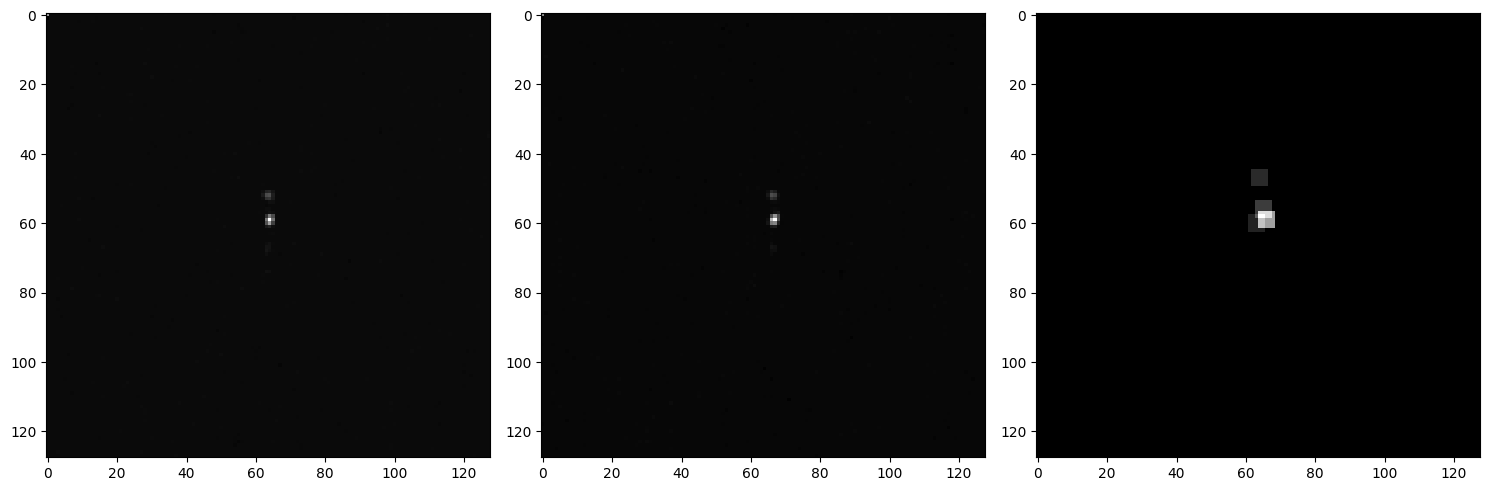

In [5]:
# 結果の表示
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(frame_a, cmap='gray')
axs[1].imshow(frame_b, cmap='gray')
axs[2].imshow(frame_c, cmap='gray')
plt.tight_layout()
plt.show()
# cv2.imwrite('frame_c.png', frame_c)